In [1]:
from casadi import *
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import sys
%matplotlib inline

In [2]:
os.environ["OMP_NUM_THREADS"] = "7"
os.environ["WORHP"] = "/usr/lib"
os.environ["WORHP_LICENSE_FILE"] = "/home/jovyan/thesis/worhp.lic"

In [3]:
def create_f_dyn(x, u, x_init):
    dist_g = np.linalg.norm([x[0]-u[0], x[1] - u[1]])
    theta_g = atan2(u[1] - x_init[1], u[0] - x_init[0])
    V = u[2]
    
    d_dot = V*(-sin(x[2])*sin(theta_g) + cos(x[2])*cos(theta_g))
    l = fmin(L1, dist_g+0.01)
    th_ddot = 2*V/l*(d_dot/l - x[3])
    return Function(
        'f',
        [x, u],
        [vertcat(V*sin(x[2]), V*cos(x[2]), x[3], th_ddot)],
        ['x', 'u'],
        ['xdot']
    )

In [4]:
# state-space equation
def create_f(x, u, x_init):
    dist_g = np.linalg.norm([x[0]-u[0], x[1] - u[1]])
    theta_g = atan2(u[1] - x_init[1], u[0] - x_init[0])
    d = -x[0]*sin(theta_g) + x[1]*cos(theta_g)
    l = fmin(L1, dist_g+0.01)
    eta1 = d/l
    eta2 = np.pi/2 - (x[2] + theta_g)
    eta = eta1 + eta2
    V = u[2]
    th_dot = fmin(2*V/l*(eta), np.pi/12)
    return Function(
        'f',
        [x, u],
        [vertcat(V*sin(x[2]), V*cos(x[2]), th_dot)],
        ['x', 'u'],
        ['xdot']
    )

In [5]:
def get_dist(X, N):
    d = 0
    for i in range(1, N):
        d += np.linalg.norm(X[:2, i] - X[:2, i-1])
    return d

In [6]:
opti = casadi.Opti()

nd = 50 # discretization points
nx = 3 # state-space dimension
nu = 3 # control dimension

X=[]
Xc=[]
U=[]
S=[]
N=[]

Xs = np.array([0.0, 0.0, 0]) # start position
Xg = [1, 0, 2*np.pi/4] # goal position
X_min = [-2, -2, 0]
X_max = [2, 2, 2*np.pi]
V_init = 0.03 # constant velocity
V_min = 0.075
V_max = 0.1
L1 = .3#*V/np.pi#(1/np.pi)*.7*V # constant dT, zeta=0.7
wp_R = 0.05 #wp vicinity radius

In [7]:
def sim_seq(U, X_init=np.array([0, 0, 0])):
    X_sim = np.zeros((nx, 1))
    X_sim[:, 0] = X_init
    for i in range(len(U)):
        X_start = X_sim[:, -1]
        f_sim = create_f(MX.sym('x', nx), MX.sym('u', nu), X_start[:2])
        Uk = U[i]
        dt = 1
        for i in range(1, 200):
            # RK4 integration
            k1 = f_sim(X_sim[:, -1], Uk)
            k2 = f_sim(X_sim[:, -1]+dt/2*k1, Uk)
            k3 = f_sim(X_sim[:, -1]+dt/2*k2, Uk)
            k4 = f_sim(X_sim[:, -1]+dt*k3, Uk)
            
            Xk = X_sim[:, -1] + dt/6*(k1+k2+k3+k4)

            X_sim = np.append(X_sim, Xk, axis=1)
                       
            rx = Xk[:2] - X_start[:2]
            ru = Uk[:2] - X_start[:2]
            rx = np.array(rx).flatten()
            
            if np.linalg.norm(rx-ru) < wp_R:
                print('wp reached in {} iterations, R'.format(i+1))
                break 

            if np.dot(rx, ru)/(np.linalg.norm(ru)**2) > 1:
                print('wp reached in {} iterations, passed'.format(i+1))
                break
    return X_sim

wp reached in 24 iterations, R


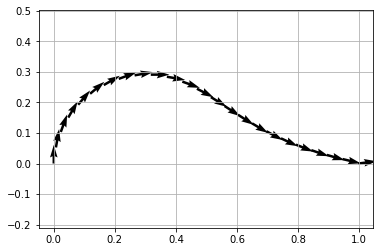

In [8]:
X_sim = sim_seq([np.array([Xg[0], Xg[1], 0.08])])
N = X_sim.shape[1]-1 
plt.quiver(X_sim[0,:], X_sim[1,:], sin(X_sim[2,:]), cos(X_sim[2,:]))
plt.grid(True)
plt.axis('equal')
plt.show()

In [9]:
def gen_init_sim(X_sim, N_i, nIt, n_c):
    X_init = np.zeros((nIt, nx, n_c))
    U_init = np.zeros((nIt, nu))
    S_init = np.zeros(nIt)
    N_init = []
    k = int(ceil(N_i/nIt))
    for i in range(nIt):
        start = i * k
        end = min((i+1) * k, N_i)
        X_init[i, 0, :] = np.linspace(X_sim[0, start], X_sim[0, end], n_c)
        X_init[i, 1, :] = np.linspace(X_sim[1, start], X_sim[1, end], n_c)
        X_init[i, 2, :] = np.linspace(X_sim[2, start], X_sim[2, end], n_c)
        U_init[i, :2] = X_sim[:2, end]
        S_init[i] = get_dist(X_sim[:2, start:end], end-start)
        N_init += [end-start]
        
    return X_init, U_init, S_init, N_init

In [10]:
def gen_init(Xg, nIt, n_c):
    X_init = np.zeros((nIt, nx, n_c))
    U_init = np.zeros((nIt, nu))
    S_init = np.zeros(nIt)
    
    x = np.linspace(0, Xg[0], nIt+1)
    y = np.linspace(0, Xg[1], nIt+1)
    th = np.linspace(0, Xg[2], nIt+1)
    
    for i in range(nIt):
        X_init[i, :] = np.vstack((
            np.linspace(x[i], x[i+1], n_c),
            np.linspace(y[i], y[i+1], n_c),
            np.linspace(th[i], th[i+1], n_c)
        ))
        U_init[i, 0] = x[i+1]
        U_init[i, 1] = y[i+1]
        S_init[i] = np.linalg.norm(X_init[i, :2, -1] - X_init[i, :2, 0])
    return X_init, U_init, S_init

In [11]:
nIt = 2
n_c = 10
d = 3
#X_init, U_init, S_init = gen_init(Xg, nIt, n_c)
X_init, U_init, S_init, _ = gen_init_sim(X_sim, N, nIt, n_c)

In [12]:
# create collocation points
tau_root = np.append(0, collocation_points(d, 'legendre'))

# Coefficients of the collocation equation
C = np.zeros((d+1,d+1))

# Coefficients of the continuity equation
D = np.zeros(d+1)

# Coefficients of the quadrature function
B = np.zeros(d+1)

# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1):
        C[j,r] = pder(tau_root[r])

    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    pint = np.polyint(p)
    B[j] = pint(1.0)

In [13]:
for i in range(nIt):
    X_i = opti.variable(nx, n_c)
    U_i = opti.variable(nu)
    S_i = opti.variable()
    
    if i == 0:
        f = create_f(X_i, U_i, [0, 0])
    else:
        f = create_f(X_i, U_i, U[i-1][:2])
    
    for k in range(n_c-1):
        Xc_k = []
        for j in range(d):
            Xkj = opti.variable(nx)
            Xc_k += [Xkj]

        x_next = D[0]*X_i[:, k]

        for j in range(1,d+1):
            # Expression for the state derivative at the collocation point
            xp = C[0,j]*X_i[:, k]
            for r in range(d):
                xp = xp + C[r+1,j]*Xc_k[r]

            # Append collocation equations
            fj = f(Xc_k[j-1], U_i)
            opti.subject_to( S_i/(n_c-1)*fj == xp )


            # Add contribution to the end state
            x_next = x_next + D[j]*Xc_k[j-1]

        opti.subject_to( X_i[:, k+1] == x_next )
        for _x in Xc_k:
            Xc += [_x]
        
    
    # state constraints
    x = X_i[0,:]
    y = X_i[1,:]
    th = X_i[2, :]
    opti.subject_to(opti.bounded(X_min[0], x, X_max[0]))
    opti.subject_to(opti.bounded(X_min[1], y, X_max[1]))
    
    # control constraints
    un_x = U_i[0]
    un_y = U_i[1]
    opti.subject_to(opti.bounded(X_min[0], un_x, X_max[0]))
    opti.subject_to(opti.bounded(X_min[1], un_y, X_max[1]))
    
    # if end coordinate fixed
    #if i == nIt - 1:
    #    opti.subject_to(un_x == Xg[0])
    #    opti.subject_to(un_y == Xg[1])
    #else:
        # add small epsilon to avoid division by zero
    opti.subject_to( np.sqrt((X_i[0, -1]-un_x)**2+(X_i[1, -1]-un_y)**2 + 0.0001) <= wp_R )
        
    V_i = U_i[2]
    opti.subject_to(opti.bounded(V_min, V_i, V_max ))
    
    # misc constraints
    opti.subject_to(S_i >= 0.0)
    
    if i == 0:
        opti.subject_to(X_i[:,0] == Xs)
    else:
        opti.subject_to( X_i[:,0] == X[i-1][:,-1])        
    
    if i == nIt - 1:
        #opti.subject_to( X_i[:2,-1] == Xg[:2]  )
        #opti.subject_to(opti.bounded( Xg[2] - 0.1, X_i[2, -1], Xg[2] + 0.1 ))
        opti.subject_to(X_i[2,-1] == Xg[2])
        
    X += [X_i]
    U += [U_i]
    S += [S_i]

In [14]:
objective = 0
for i in range(nIt):
    objective += S[i]
    opti.set_initial(S[i], S_init[i])
    opti.set_initial(X[i], X_init[i])
    opti.set_initial(U[i], U_init[i])

#objective += (Xg[2]-X[nIt-1][2,-1])**2
opti.minimize(objective)

solver = "ipopt"

if solver == "ipopt":
    p_opts  ={"expand": True, "print_time" : False }
    s_opts = {"linear_solver": "ma57", "max_iter" : 50000, "print_level" : 5, "mu_init" : 0.1, "tol": 1e-5 }
    opti.solver('ipopt', p_opts, s_opts)
elif solver == "sqpmethod":
    s_opts = {"print_iter": False, "print_header" : False}
    p_opts = {"expand": True, "qpsol" : "qrqp", "qpsol_options" : s_opts, "print_iteration" : True, "print_header" : False, "print_status" : False}
    opti.solver('sqpmethod',p_opts)
elif solver == "worhp" :
    p_opts  ={"expand": True, "print_time" : False }
    s_opts = {"MaxIter": 500,"NLPprint": 2, "BFGSmethod" : 3, "LineSearchMethod": 1, "RegStrategy": 3, "SwitchMode": 0, "RefineFeasibility": 0,  "RefineFeasTermination": 1, "RefineContrLimitq": 10**-6, "RefineContrLimitc": 8*10**-4}
    opti.solver('worhp', p_opts, s_opts)

opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     1630
Number of nonzeros in inequality constraint Jacobian.:       56
Number of nonzeros in Lagrangian Hessian.............:     1174

Reallocating memory for MA57: lfact (18058)
Total number of variables............................:      230
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:

 128  5.6776130e+00 3.04e-01 5.33e+00  -1.0 2.10e-01  -0.9 1.00e+00 3.12e-02h  6
 129  5.6801317e+00 3.03e-01 1.23e+02  -1.0 3.55e-01  -1.4 1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  5.4930394e+00 4.78e-01 8.41e+00  -1.0 1.63e-01    -  1.00e+00 1.00e+00h  1
 131  5.6197796e+00 3.58e-01 6.31e+00  -1.0 3.74e-01  -0.9 1.00e+00 2.50e-01h  3
 132  5.6673071e+00 3.14e-01 5.52e+00  -1.0 6.24e-01  -1.4 1.00e+00 1.25e-01h  4
 133  5.6777038e+00 3.05e-01 1.21e+02  -1.0 2.24e-01  -1.0 1.00e+00 3.12e-02h  6
 134  5.4868342e+00 4.84e-01 8.36e+00  -1.0 1.77e-01    -  1.00e+00 1.00e+00h  1
 135  5.4923287e+00 4.78e-01 8.27e+00  -1.0 1.08e+01  -1.5 1.78e-01 1.07e-02h  6
 136  5.6192465e+00 3.59e-01 6.20e+00  -1.0 4.42e-01  -1.0 1.00e+00 2.50e-01h  3
 137  5.6430436e+00 3.36e-01 5.81e+00  -1.0 9.04e-01  -1.5 1.00e+00 6.25e-02h  5
 138  5.6486211e+00 3.31e-01 5.72e+00  -1.0 2.58e-01  -1.1 1.00e+00 1.56e-02h  7
 139  5.6513662e+00 3.29e-01

 261  5.9409375e+00 6.84e-01 1.13e+01  -1.7 9.31e-01   0.9 5.37e-01 6.37e-01h  1
 262  5.9321505e+00 5.48e-01 8.68e+00  -1.7 8.70e-01   0.4 1.32e-01 1.71e-01h  2
 263  5.5281076e+00 3.11e-01 4.18e+00  -1.7 7.45e-01  -0.1 3.17e-01 3.80e-01h  1
 264  4.4076134e+00 2.49e-01 5.50e+00  -1.7 1.52e+00  -0.5 1.47e-01 5.66e-01f  1
 265  3.8819751e+00 3.23e-01 2.55e+00  -1.7 6.31e-01  -0.1 8.56e-01 7.74e-01f  1
 266  4.9635628e+00 1.30e-01 1.95e+01  -1.7 1.08e+00  -0.6 1.00e+00 5.11e-01h  1
 267  4.8938010e+00 5.33e-02 1.90e+01  -1.7 2.13e-01   0.7 1.00e+00 1.00e+00h  1
 268  5.1703507e+00 1.53e-01 4.18e+01  -1.7 6.00e-01    -  4.91e-01 2.50e-01h  3
 269  4.8214424e+00 1.10e+00 6.38e+01  -1.7 3.66e-01   0.3 1.00e+00 5.62e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  4.6700407e+00 9.32e-01 3.94e+01  -1.7 4.32e-01   0.7 6.39e-01 3.40e-01h  1
 271  4.6653305e+00 8.88e-01 3.76e+01  -1.7 3.40e-01   0.2 8.68e-01 4.63e-02h  1
 272  4.5281820e+00 5.84e-01

 381  5.9078502e+00 8.68e-02 7.36e+00  -1.7 6.91e-02  -0.5 1.00e+00 2.50e-01h  3
 382  5.9308877e+00 6.51e-02 5.52e+00  -1.7 6.59e-02  -1.0 1.00e+00 2.50e-01h  3
 383  5.9319676e+00 6.41e-02 5.43e+00  -1.7 4.75e-02  -1.5 1.00e+00 1.56e-02h  7
 384  5.9324991e+00 6.36e-02 5.39e+00  -1.7 3.83e-02  -1.0 1.00e+00 7.81e-03h  8
 385  5.9326309e+00 6.35e-02 5.38e+00  -1.7 3.78e-02  -1.5 1.00e+00 1.95e-03h 10
 386  5.9326474e+00 6.35e-02 5.38e+00  -1.7 3.82e-02  -1.1 1.00e+00 2.44e-04h 13
 387  5.9326556e+00 6.35e-02 5.38e+00  -1.7 4.48e-02  -1.6 1.00e+00 1.22e-04h 14
 388  5.9326576e+00 6.35e-02 5.38e+00  -1.7 3.78e-02  -1.1 1.00e+00 3.05e-05h 16
 389r 5.9326576e+00 6.35e-02 9.99e+02  -1.2 0.00e+00  -1.6 0.00e+00 4.77e-07R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 5.9993597e+00 2.11e-01 9.72e+02  -1.2 6.26e+01    -  2.71e-02 1.00e-03f  1
 391r 6.0085192e+00 2.04e-01 5.75e+00  -1.2 2.34e-01    -  1.00e+00 3.04e-02f  1
 392r 6.0786478e+00 2.11e-01

 525  4.2573075e+00 4.98e-01 4.87e+02  -1.7 7.58e-01   0.5 5.50e-02 2.94e-02h  1
 526  4.3188405e+00 3.83e-01 2.43e+02  -1.7 3.71e-01   1.0 1.00e+00 2.08e-01f  1
 527  4.1557177e+00 7.56e-01 8.67e+01  -1.7 3.02e-01   0.5 5.21e-01 7.30e-01h  1
 528  3.9485836e+00 6.16e-01 4.12e+01  -1.7 6.13e-01   0.0 1.00e+00 1.00e+00f  1
 529  4.6508921e+00 4.05e-01 2.71e+01  -1.7 1.53e+00  -0.5 1.00e+00 3.42e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  4.8195306e+00 3.55e-01 2.37e+01  -1.7 1.70e+00  -0.9 1.00e+00 1.25e-01h  4
 531  4.8073329e+00 3.44e-01 2.26e+01  -1.7 8.13e-01   1.3 3.12e-02 3.12e-02h  6
 532  5.0503934e+00 8.06e-01 1.19e+01  -1.7 2.75e-01   0.8 1.00e+00 9.15e-01H  1
 533  5.3372648e+00 5.62e-01 8.28e+00  -1.7 4.92e-01   0.3 1.00e+00 3.02e-01h  2
 534  5.5029486e+00 4.22e-01 6.21e+00  -1.7 3.47e-01  -0.1 1.00e+00 2.50e-01h  3
 535  5.5650800e+00 3.69e-01 5.43e+00  -1.7 2.76e-01  -0.6 1.00e+00 1.25e-01h  4
 536  5.6194450e+00 3.23e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810r 5.9998427e+00 7.69e-02 6.48e+02  -1.7 1.25e+01    -  3.52e-01 1.25e-03f  1
 811r 6.0030325e+00 7.27e-02 5.03e-01  -1.7 1.25e-01    -  1.00e+00 3.98e-01f  1
 812r 5.9979377e+00 8.14e-03 2.71e-01  -2.5 5.56e-02    -  1.00e+00 1.00e+00f  1
 813r 5.9863033e+00 2.44e-01 4.42e-02  -2.5 9.66e-02    -  1.00e+00 1.00e+00h  1
 814r 5.9646475e+00 1.72e-01 1.28e-01  -2.5 1.02e-01    -  1.00e+00 2.50e-01h  3
 815r 5.9576649e+00 1.53e-01 1.85e-01  -2.5 9.89e-02    -  1.00e+00 1.10e-01h  4
 816r 5.9523806e+00 1.43e-01 2.21e-01  -2.5 7.53e-02    -  1.00e+00 6.25e-02h  5
 817r 5.9466439e+00 1.34e-01 2.21e-01  -2.5 7.54e-02    -  1.00e+00 6.25e-02h  5
 818r 5.9459559e+00 1.33e-01 1.99e-01  -2.5 7.42e-02    -  1.00e+00 7.81e-03h  8
 819r 5.8892269e+00 9.13e-02 2.37e-01  -2.5 7.44e-02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820r 5.8436503e+00 9.89e-02

Reallocating memory for MA57: lfact (105078)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160  1.7407514e+00 3.23e-01 3.67e+10  -1.7 1.89e+00  11.9 5.84e-04 1.85e-02h  1
1161  1.9143567e+00 3.10e-01 2.83e+12  -1.7 2.34e+00  11.4 1.00e+00 4.08e-02h  1
1162  1.9160859e+00 3.09e-01 2.21e+12  -1.7 2.24e+00  10.9 4.32e-01 4.23e-04h  1
1163  1.9161508e+00 3.09e-01 7.64e+11  -1.7 2.25e+00  10.4 1.00e+00 1.59e-05h  1
1164  1.9301678e+00 3.08e-01 6.74e+11  -1.7 2.29e+00  10.0 4.39e-01 3.43e-03h  1
1165  2.1163823e+00 3.12e-01 1.23e+13  -1.7 2.25e+00  10.4 1.00e+00 4.58e-02h  1
1166  2.1240406e+00 3.11e-01 1.22e+13  -1.7 6.81e+00    -  1.97e-01 1.97e-03h  1
1167  2.1742914e+00 3.07e-01 1.21e+13  -1.7 6.60e+00    -  8.17e-01 1.31e-02h  5
1168  2.1750847e+00 3.07e-01 1.21e+13  -1.7 6.30e+00    -  3.87e-02 2.08e-04h 12
1169r 2.1750847e+00 3.07e-01 1.00e+03  -0.5 0.00e+00  11.7 0.00e+00 2.90e-07R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha

1329  6.0000000e+00 1.01e-10 3.98e+01  -1.7 4.80e-04   3.2 9.90e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330  6.0000000e+00 4.27e-05 1.05e+01  -1.7 3.92e-01    -  7.36e-01 2.50e-01f  3
1331  6.0000000e+00 2.35e-08 1.66e+00  -1.7 3.24e-03   2.7 1.00e+00 1.00e+00f  1
1332  6.0000000e+00 8.71e-09 7.98e-01  -1.7 4.68e-03   2.2 1.00e+00 1.00e+00f  1
1333  6.0000000e+00 2.26e-03 1.13e+00  -1.7 8.04e-01    -  9.85e-01 1.00e+00f  1
1334  6.0000000e+00 2.38e-03 1.08e+00  -1.7 7.36e+00    -  1.00e+00 3.70e-02h  5
1335  6.0000000e+00 1.14e-02 8.91e+01  -1.7 8.71e-01    -  1.00e+00 7.81e-03h  8
1336  5.9915513e+00 6.62e-01 4.10e+02  -1.7 1.05e-02   1.8 1.00e+00 1.00e+00h  1
1337  5.9860608e+00 1.60e-01 1.21e+02  -1.7 2.57e-02   1.3 1.00e+00 1.00e+00h  1
1338  5.9184641e+00 9.37e-02 2.44e+01  -1.7 3.70e-02   0.8 1.00e+00 1.00e+00h  1
1339  5.6741525e+00 3.07e-01 1.09e+00  -1.7 1.27e-01   0.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1805r 4.9027062e+00 3.79e-01 5.31e+06  -0.6 8.39e-02   7.6 1.27e-01 7.48e-02h  1
1806r 4.9027091e+00 3.79e-01 5.30e+06  -0.6 7.78e-02   8.0 4.31e-02 8.40e-04h  1
1807r 4.9027117e+00 3.78e-01 5.30e+06  -0.6 8.04e-02   8.4 2.03e-04 7.17e-04h  1
1808r 4.9030952e+00 3.43e-01 4.71e+06  -0.6 7.94e-02   8.0 1.93e-03 1.09e-01h  1
1809r 4.9030997e+00 3.43e-01 4.73e+06  -0.6 7.06e-02   8.4 1.06e-02 1.26e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1810r 4.9031036e+00 3.42e-01 4.87e+06  -0.6 7.00e-02   7.9 2.81e-03 1.12e-03f  6
1811r 4.9031110e+00 3.42e-01 4.85e+06  -0.6 7.11e-02   8.3 5.06e-03 2.28e-03h  1
1812r 4.9031154e+00 3.41e-01 4.75e+06  -0.6 3.61e-01   7.9 2.40e-04 3.59e-03f  1
1813r 4.9031997e+00 3.34e-01 6.92e+06  -0.6 7.04e-02   8.3 8.29e-02 2.35e-02h  1
1814r 4.9032890e+00 3.26e-01 6.72e+06  -0.6 6.85e-02   7.8 1.43e-02 2.88e-02h  1
1815r 4.9039884e+00 2.64e-01 6.51e+06  -0.6 6.69e-02   8.2 5.77e-02 2.28e-01h  1
1816r 4.9041338e+00 2.53e-01

Complementarity.........:   9.0916590471484149e-07    9.0916590471484149e-07
Overall NLP error.......:   8.8484590071910975e-06    8.8484590071910975e-06


Number of objective function evaluations             = 6737
Number of objective gradient evaluations             = 1264
Number of equality constraint evaluations            = 6738
Number of inequality constraint evaluations          = 6738
Number of equality constraint Jacobian evaluations   = 1928
Number of inequality constraint Jacobian evaluations = 1928
Number of Lagrangian Hessian evaluations             = 1912
Total CPU secs in IPOPT (w/o function evaluations)   =      2.730
Total CPU secs in NLP function evaluations           =      1.010

EXIT: Optimal Solution Found.


OptiSol(Opti {
  instance #0
  #variables: 60 (nx = 230)
  #parameters: 0 (np = 0)
  #constraints: 89 (ng = 273)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

wp reached in 3 iterations, R
wp reached in 8 iterations, R


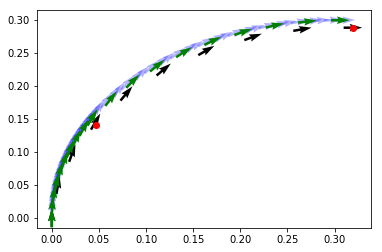

In [15]:
X_sim = sim_seq(list(filter(lambda u: np.linalg.norm(u[:2]) > wp_R, [opti.debug.value(u) for u in U])))
plt.quiver(X_sim[0, :], X_sim[1, :], sin(X_sim[2, :]), cos(X_sim[2, :]), color='black', pivot='mid')
for _, Xck in enumerate(Xc):
    x = opti.debug.value(Xck)
    plt.quiver(x[0], x[1], sin(x[2]), cos(x[2]), color='blue', alpha=.3)
for i in range(nIt):
    x = opti.debug.value(X[i])
    u = opti.debug.value(U[i])
    plt.quiver(x[0], x[1], sin(x[2]), cos(x[2]), color='green', pivot='mid')
    plt.scatter(u[0], u[1], color='red')
plt.show()

In [16]:
[opti.debug.value(s) for s in S]

[2.1017499110248563, 3.8982500889751988]

In [17]:
os.environ

environ{'MINICONDA_VERSION': '4.5.12',
        'LANGUAGE': 'en_US.UTF-8',
        'HOSTNAME': '733f4bac9b42',
        'XDG_CACHE_HOME': '/home/jovyan/.cache/',
        'HOME': '/home/jovyan',
        'CONDA_VERSION': '4.6.14',
        'NB_USER': 'jovyan',
        'PATH': '/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'NB_GID': '100',
        'LANG': 'en_US.UTF-8',
        'DEBIAN_FRONTEND': 'noninteractive',
        'SHELL': '/bin/bash',
        'CONDA_DIR': '/opt/conda',
        'LC_ALL': 'en_US.UTF-8',
        'PWD': '/home/jovyan',
        'NB_UID': '1000',
        'JPY_PARENT_PID': '7',
        'TERM': 'xterm-color',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
        'OMP_NUM_THREADS': '7',
        'WORHP': '/usr/lib',
        'WORHP_LICENSE_FILE': '/home/jovyan/thesis/worhp.lic'}